# Optimizing CNN's architecture using genetic algorithms

## Dataset 02: CIFAR-10

### 01. Importing Libraries

In [4]:
# Importação de Bibliotecas
import time
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, random_split
from deap import base, creator, tools, algorithms
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

### 02. Dataset division: Train, test, and validation

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# Dividindo o trainset em treino e validação
val_size = int(0.1 * len(trainset))
train_size = len(trainset) - val_size
trainset, validset = random_split(trainset, [train_size, val_size])

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
validloader = DataLoader(validset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=100, shuffle=False)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 170498071/170498071 [00:43<00:00, 3939681.45it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


### 03. CNN Architecture

In [5]:
class SimpleNet(nn.Module):
    def __init__(self, n_neurons, activation_fn):
        super(SimpleNet, self).__init__()
        # Primeira camada convolucional: 3 canais de entrada (CIFAR-10), 32 canais de saída, kernel 3x3
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        # Segunda camada convolucional: 32 canais de entrada, 64 de saída, kernel 3x3
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        # Terceira camada convolucional: 64 canais de entrada, 128 de saída, kernel 3x3
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        # Camada totalmente conectada
        self.fc1 = nn.Linear(128 * 4 * 4, n_neurons)
        self.activation = activation_fn
        self.fc2 = nn.Linear(n_neurons, 10)  # CIFAR-10 tem 10 classes

    def forward(self, x):
        # Primeira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        # Segunda camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        # Terceira camada convolucional seguida de ReLU e MaxPooling
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, 2)
        # Achatar a saída para a camada totalmente conectada
        x = x.view(-1, 128 * 4 * 4)
        x = self.fc1(x)
        x = self.activation(x)
        x = self.fc2(x)
        return x


### 04. Training and model evaluation function

In [6]:
# Função de treinamento e avaliação
def train_and_evaluate(model, trainloader, testloader, criterion, optimizer, num_epochs=10):
    start_time = time.time()
    train_losses = []
    
    for epoch in tqdm(range(num_epochs), desc='Treinamento', unit='época'):
        running_loss = 0.0
        for inputs, labels in tqdm(trainloader, desc='Batchs', leave=False, unit='batch'):
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        avg_loss = running_loss / len(trainloader)
        train_losses.append(avg_loss)
        print(f"Época {epoch + 1}, Loss: {avg_loss:.4f}")
    
    total = 0
    correct = 0
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for inputs, labels in tqdm(testloader, desc='Avaliação', unit='batch'):
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = correct / total
    time_taken = time.time() - start_time
    cm = confusion_matrix(all_labels, all_preds)
    return accuracy, train_losses, time_taken, cm

### 05. Genetic Algorithm

In [7]:
# Função de avaliação do indivíduo
def evaluate_individual(individual):
    n_neurons, activation_idx, learning_rate, batch_size = individual

    # Certifique-se de que activation_idx esteja dentro do intervalo esperado
    activation_idx = min(max(activation_idx, 0), 1)
    activation_fn = [nn.ReLU(), nn.Sigmoid()][activation_idx]
    
    model = SimpleNet(n_neurons, activation_fn)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Treinamento no conjunto de treinamento
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
    for epoch in range(3):  # Treinando por 3 épocas como exemplo
        for inputs, labels in trainloader:
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Avaliação no conjunto de validação
    validloader = torch.utils.data.DataLoader(validset, batch_size=batch_size, shuffle=False)
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in validloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = correct / total
    return accuracy,

In [8]:
# Configuração do Algoritmo Genético
creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", random.randint, 10, 200)  # Número de neurônios
toolbox.register("attr_activation", random.randint, 0, 1)  # Função de ativação (ReLU ou Sigmoid)
toolbox.register("attr_float", random.uniform, 0.001, 0.1)  # Taxa de aprendizado
toolbox.register("attr_batch", random.randint, 32, 128)  # Tamanho do batch

toolbox.register("individual", tools.initCycle, creator.Individual, 
                 (toolbox.attr_int, toolbox.attr_activation, toolbox.attr_float, toolbox.attr_batch), n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("evaluate", evaluate_individual)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=10, up=200, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético
population = toolbox.population(n=10)
NGEN = 5
for gen in tqdm(range(NGEN), desc='Gerações'):
    offspring = algorithms.varAnd(population, toolbox, cxpb=0.5, mutpb=0.2)
    
    fits = list(tqdm(map(toolbox.evaluate, offspring), total=len(offspring), desc="Avaliando Indivíduos"))
    
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    population = toolbox.select(offspring, k=len(population))

# Seleciona o melhor indivíduo
top_ind = tools.selBest(population, k=1)[0]

# Parâmetros do melhor indivíduo
best_params = {
    'n_neurons': top_ind[0],
    'activation_idx': top_ind[1],
    'learning_rate': top_ind[2],
    'batch_size': top_ind[3]
}

Gerações: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [7:03:34<00:00, 5082.99s/it]


In [9]:
print("Melhor indivíduo:", top_ind)
print("Parâmetros:", best_params)

Melhor indivíduo: [36, 0, 0.09473253224368378, 30]
Parâmetros: {'n_neurons': 36, 'activation_idx': 0, 'learning_rate': 0.09473253224368378, 'batch_size': 30}


### 06. Model training

#### Model 1 - Not Optimized

In [10]:
# Modelo Não Otimizado
model_non_opt_1 = SimpleNet(n_neurons=50, activation_fn=nn.Sigmoid())
criterion_1 = nn.CrossEntropyLoss()
optimizer_1 = optim.SGD(model_non_opt_1.parameters(), lr=0.05)

accuracy_non_opt_1, train_losses_non_opt_1, time_non_opt_1, cm_non_opt_1 = train_and_evaluate(model_non_opt_1, trainloader, testloader, criterion_1, optimizer_1)

Treinamento:  10%|█████████████▌                                                                                                                         | 1/10 [01:42<15:23, 102.65s/época]

Época 1, Loss: 2.1961



Treinamento:  20%|███████████████████████████                                                                                                            | 2/10 [03:35<14:28, 108.51s/época]

Época 2, Loss: 1.8245



Treinamento:  30%|████████████████████████████████████████▌                                                                                              | 3/10 [05:43<13:41, 117.36s/época]

Época 3, Loss: 1.5689



Treinamento:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [07:43<11:51, 118.66s/época]

Época 4, Loss: 1.4311



Treinamento:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [09:25<09:23, 112.62s/época]

Época 5, Loss: 1.3218



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [11:00<07:06, 106.55s/época]

Época 6, Loss: 1.2069



Treinamento:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [12:34<05:07, 102.47s/época]

Época 7, Loss: 1.0994



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [14:16<03:24, 102.33s/época]

Época 8, Loss: 1.0149



Treinamento:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [16:26<01:50, 110.85s/época]

Época 9, Loss: 0.9290



Treinamento: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:18<00:00, 109.82s/época]


Época 10, Loss: 0.8647


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.76batch/s]


#### Model 2 - Not Optimized

In [11]:
# Modelo Não Otimizado
model_non_opt_2 = SimpleNet(n_neurons=20, activation_fn=nn.ReLU())
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_non_opt_2.parameters(), lr=0.05)

accuracy_non_opt_2, train_losses_non_opt_2, time_non_opt_2, cm_non_opt_2 = train_and_evaluate(model_non_opt_2, trainloader, testloader, criterion_2, optimizer_2)

Treinamento:  10%|█████████████▌                                                                                                                         | 1/10 [01:44<15:40, 104.54s/época]

Época 1, Loss: 1.9076



Treinamento:  20%|███████████████████████████                                                                                                            | 2/10 [03:48<15:29, 116.21s/época]

Época 2, Loss: 1.4566



Treinamento:  30%|████████████████████████████████████████▌                                                                                              | 3/10 [05:56<14:08, 121.29s/época]

Época 3, Loss: 1.2402



Treinamento:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [07:48<11:47, 117.87s/época]

Época 4, Loss: 1.0659



Treinamento:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [09:42<09:41, 116.22s/época]

Época 5, Loss: 0.9368



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [12:22<08:45, 131.28s/época]

Época 6, Loss: 0.8379



Treinamento:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [14:36<06:36, 132.07s/época]

Época 7, Loss: 0.7567



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [16:47<04:23, 131.66s/época]

Época 8, Loss: 0.6909



Treinamento:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [19:24<02:19, 139.62s/época]

Época 9, Loss: 0.6332



Treinamento: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [21:41<00:00, 130.20s/época]


Época 10, Loss: 0.5775


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.50batch/s]


#### Model 3 - Not Optimized

In [12]:
# Modelo Não Otimizado
model_non_opt_3 = SimpleNet(n_neurons=150, activation_fn=nn.Sigmoid())
criterion_3 = nn.CrossEntropyLoss()
optimizer_3 = optim.SGD(model_non_opt_3.parameters(), lr=0.07)

accuracy_non_opt_3, train_losses_non_opt_3, time_non_opt_3, cm_non_opt_3 = train_and_evaluate(model_non_opt_3, trainloader, testloader, criterion_3, optimizer_3)

Treinamento:  10%|█████████████▌                                                                                                                         | 1/10 [01:58<17:47, 118.63s/época]

Época 1, Loss: 2.0753



Treinamento:  20%|███████████████████████████                                                                                                            | 2/10 [04:02<16:12, 121.50s/época]

Época 2, Loss: 1.6491



Treinamento:  30%|████████████████████████████████████████▌                                                                                              | 3/10 [06:15<14:47, 126.85s/época]

Época 3, Loss: 1.4343



Treinamento:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [08:33<13:08, 131.44s/época]

Época 4, Loss: 1.2746



Treinamento:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [10:49<11:05, 133.10s/época]

Época 5, Loss: 1.1283



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [12:48<08:33, 128.28s/época]

Época 6, Loss: 1.0015



Treinamento:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [14:56<06:24, 128.01s/época]

Época 7, Loss: 0.8963



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [16:47<04:05, 122.61s/época]

Época 8, Loss: 0.8182



Treinamento:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [18:39<01:59, 119.27s/época]

Época 9, Loss: 0.7441



Treinamento: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [20:29<00:00, 122.98s/época]


Época 10, Loss: 0.6774


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:11<00:00,  8.57batch/s]


#### Model 4 - Optimized Model

In [13]:
# Modelo Otimizado
activation_fn = [nn.ReLU(), nn.Sigmoid()][best_params['activation_idx']]
model_opt = SimpleNet(best_params['n_neurons'], activation_fn=activation_fn)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_opt.parameters(), lr=best_params['learning_rate'])

accuracy_opt, train_losses_opt, time_opt, cm_opt = train_and_evaluate(model_opt, trainloader, testloader, criterion, optimizer)

Treinamento:  10%|█████████████▌                                                                                                                         | 1/10 [01:44<15:39, 104.37s/época]

Época 1, Loss: 1.7800



Treinamento:  20%|███████████████████████████                                                                                                            | 2/10 [03:27<13:51, 103.90s/época]

Época 2, Loss: 1.3158



Treinamento:  30%|████████████████████████████████████████▊                                                                                               | 3/10 [05:02<11:37, 99.70s/época]

Época 3, Loss: 1.0711



Treinamento:  40%|██████████████████████████████████████████████████████                                                                                 | 4/10 [06:52<10:23, 103.89s/época]

Época 4, Loss: 0.9060



Treinamento:  50%|███████████████████████████████████████████████████████████████████▌                                                                   | 5/10 [08:43<08:51, 106.33s/época]

Época 5, Loss: 0.7852



Treinamento:  60%|█████████████████████████████████████████████████████████████████████████████████                                                      | 6/10 [10:37<07:15, 108.88s/época]

Época 6, Loss: 0.6941



Treinamento:  70%|██████████████████████████████████████████████████████████████████████████████████████████████▌                                        | 7/10 [12:28<05:28, 109.46s/época]

Época 7, Loss: 0.6179



Treinamento:  80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████                           | 8/10 [14:21<03:41, 110.67s/época]

Época 8, Loss: 0.5533



Treinamento:  90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌             | 9/10 [16:16<01:52, 112.07s/época]

Época 9, Loss: 0.4895



Treinamento: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [18:31<00:00, 111.19s/época]


Época 10, Loss: 0.4387


Avaliação: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:16<00:00,  6.01batch/s]


### 07. Evaluating Models

In [14]:
# Comparação dos Resultados
print(f"Modelo Não Otimizado 1: Acurácia = {accuracy_non_opt_1:.4f}, Loss = {train_losses_non_opt_1[-1]:.4f}, Tempo = {time_non_opt_1:.2f}s")
print(f"Modelo Não Otimizado 2: Acurácia = {accuracy_non_opt_2:.4f}, Loss = {train_losses_non_opt_2[-1]:.4f}, Tempo = {time_non_opt_2:.2f}s")
print(f"Modelo Não Otimizado 3: Acurácia = {accuracy_non_opt_3:.4f}, Loss = {train_losses_non_opt_3[-1]:.4f}, Tempo = {time_non_opt_3:.2f}s")
print(f"Modelo Otimizado: Acurácia = {accuracy_opt:.4f}, Loss = {train_losses_opt[-1]:.4f}, Tempo = {time_opt:.2f}s")

Modelo Não Otimizado 1: Acurácia = 0.6704, Loss = 0.8647, Tempo = 1112.98s
Modelo Não Otimizado 2: Acurácia = 0.5334, Loss = 0.5775, Tempo = 1317.36s
Modelo Não Otimizado 3: Acurácia = 0.6693, Loss = 0.6774, Tempo = 1241.45s
Modelo Otimizado: Acurácia = 0.7049, Loss = 0.4387, Tempo = 1128.51s


| Model                    | Accuracy (%) | Training Time (s) |
|--------------------------|--------------|-------------------|
| Model 1 - Non Optimized  |     67,04    |       1112,98     |
| Model 2 - Non Optimized  |     53,34    |       1317,36     |
| Model 3 - Non Optimized  |     66,93    |       1241,45     |
| Model 4 - Optimized      |     70,49    |       1128,51     |

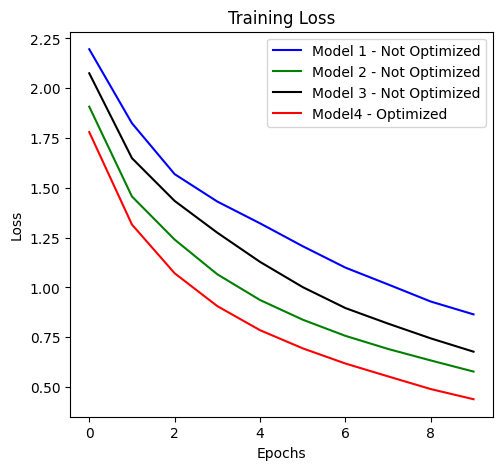

In [15]:
# Plotando gráficos comparativos
plt.figure(figsize=(12, 5))

# Gráfico da perda de treinamento
plt.subplot(1, 2, 1)
plt.plot(train_losses_non_opt_1, label='Model 1 - Not Optimized', color='blue')
plt.plot(train_losses_non_opt_2, label='Model 2 - Not Optimized', color='green')
plt.plot(train_losses_non_opt_3, label='Model 3 - Not Optimized', color='black')
plt.plot(train_losses_opt, label='Model4 - Optimized', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

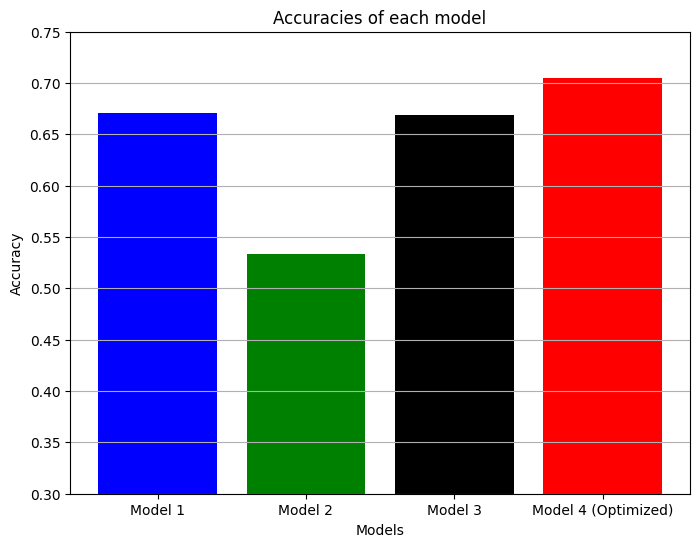

In [18]:
# Acuracias
final_accuracies = [accuracy_non_opt_1, accuracy_non_opt_2, accuracy_non_opt_3, accuracy_opt]

# Nomes dos modelos
model_names = ['Model 1', 'Model 2', 'Model 3', 'Model 4 (Optimized)']

# Configuração do gráfico de barras
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, final_accuracies, color=['blue', 'green', 'black', 'red'])
# Configurações do gráfico
plt.ylim([0.30, 0.75])  # Ajuste o limite do eixo Y para destacar as diferenças pequenas
plt.title('Accuracies of each model')
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.grid(True, axis='y')

plt.show()

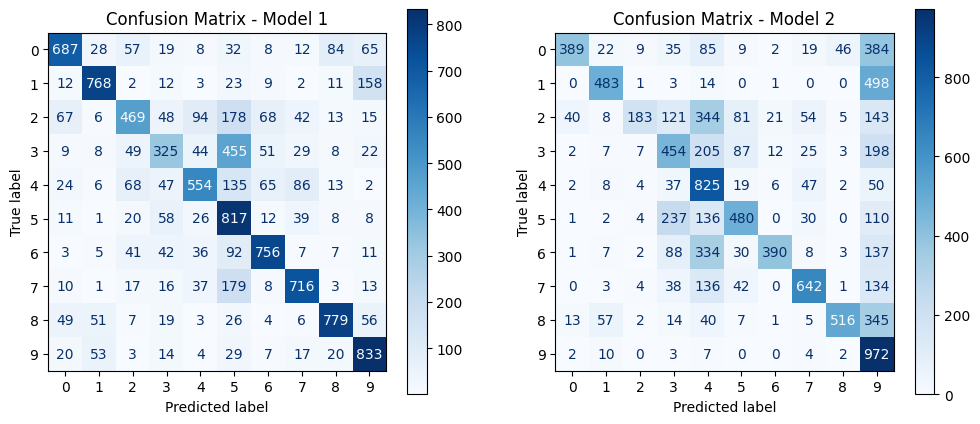

In [19]:
# Plotando a Matriz de Confusão
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 1
disp_non_opt_1 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_1, display_labels=range(10))
disp_non_opt_1.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 1')

# Matriz de Confusão - Modelo Não Otimizado 2
disp_non_opt_2 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_2, display_labels=range(10))
disp_non_opt_2.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 2')

plt.show()

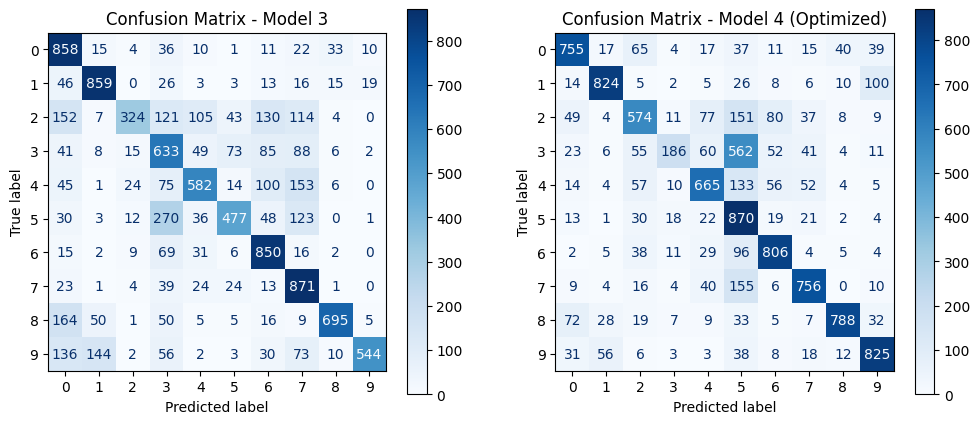

In [20]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Matriz de Confusão - Modelo Não Otimizado 3
disp_non_opt_3 = ConfusionMatrixDisplay(confusion_matrix=cm_non_opt_3, display_labels=range(10))
disp_non_opt_3.plot(ax=ax[0], cmap=plt.cm.Blues, values_format='d')
ax[0].set_title('Confusion Matrix - Model 3')

# Matriz de Confusão - Modelo Otimizado
disp_opt = ConfusionMatrixDisplay(confusion_matrix=cm_opt, display_labels=range(10))
disp_opt.plot(ax=ax[1], cmap=plt.cm.Blues, values_format='d')
ax[1].set_title('Confusion Matrix - Model 4 (Optimized)')

plt.show()